# Funciones

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import seaborn as sns

def define_H(x):
  ones = np.ones_like(x[:,0])
  H = np.vstack((ones,x.T)).T
  return H

def normalize(X):
  'X is feature vector (samples x features)'
  df_norm = np.zeros_like(X)
  for i in range(np.size(X,1)): # Each feature
    df_norm[:,i] = (X[:,i] - np.mean(X[:,i],0)) / np.std(X[:,i],0)
  return df_norm

def cost_fn(theta,H,y,c):
  'Logistic regression fn, using cross-entropy:'
  ' Theta = initial guess,'
  ' H     = Predictor matrix, '
  ' y     = labels, '
  ' c     = regularization parameter'
  z = 1 / (1 + np.exp(- (H @ theta.T)))
  z = np.clip(z, 0.0000000001, 0.9999)
  J = - np.sum((y * np.log(z)) + ((1 - y) * (np.log(1 - z)))) + (c * np.linalg.norm(theta,2)**2)
  return J

def mean_cov(X):
  'X is feature vector (samples x features)'
  n = np.size(X,0)
  m_vector = np.sum(X,0)/n
  Q = np.zeros((np.size(m_vector,0),np.size(m_vector,0)))
  for i in range(np.size(Q,0)):
    for j in range(np.size(Q,1)):
      Q[i,j] = np.sum((X[:,i] - m_vector[i]) * (X[:,j] - m_vector[j])) / (n - 1)
  return [m_vector, Q]

def mult_Gauss(x_, u_v, Qf, lambd = 1):
  n = np.size(Qf,0)
  I = np.eye(n)
  Qf = Qf  + (lambd * I)
  p_x = np.zeros_like(x_[:,1])
  for i in range(np.size(x_,0)): # samples
    p_x[i] = (1/np.sqrt(np.linalg.det(Qf))) * (1/((2*np.pi)**n/2)) * np.exp(-1/2 * (x_[i,:]-u_v).T  @ np.linalg.inv(Qf) @  (x_[i,:]-u_v))
  return p_x

def class_error(Y,Cf):
  err = 0
  for i in range(len(Y)):
    if Y[i] != Cf[i]:
      err += 1
  per_err = 100 * err/len(Y)
  return per_err

def conf_matrix(Y,Cf):
  err = np.zeros([2,2])
  for i in range(len(Y)):
    if Y[i] == 1 and Cf[i]== 1:
      err[0,0] += 1
    elif Y[i] == 0 and Cf[i]== 1:
      err[0,1] += 1
    elif Y[i] == 1 and Cf[i]== 0:
      err[1,0] += 1
    elif Y[i] == 0 and Cf[i]== 0:
      err[1,1] += 1
  per_err = 100 * (err/len(Y))
  sns.heatmap(per_err,
            cmap = 'jet',
            annot=True,
            fmt='g',
            xticklabels=['Cáncer','No Cáncer'],
            yticklabels=['Cáncer','No Cáncer'])
  plt.ylabel('Predicho',fontsize=13)
  plt.xlabel('Actual',fontsize=13)
  #plt.title('Matriz de confusión',fontsize=17)
  plt.show()
  return per_err

In [7]:
# Read dataframe
df_labels = pd.read_csv('breastCancerLabel.csv')
df = pd.read_csv('breastCancerX.csv')

# Convert to numpy
df_np = pd.DataFrame.to_numpy(df)
df_np_labels = pd.DataFrame.to_numpy(df_labels)

df_norm = normalize(df_np)
df

,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,fractal_dimension_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


# Punto 1

In [ ]:
X = df_norm[:,(0,4)]
Y = df_np_labels

# Regresión logística
c = 100
y = Y.T              # Etiqueta
H = define_H(X)      # Matriz de características
theta = np.ones((np.size(H,1)))  # Punto inicial

b_values = [theta[0]]
w_values = [(theta[1], theta[2])]

criteria = False
while criteria == False:
  coef = minimize(cost_fn, x0 = theta, args=(H,y,c), options={'maxiter':1}) # Numeric solution

  # Actualizamos valores
  theta = coef['x']

  # Extraemos valores de la iteración
  b_values.append(coef['x'][0])
  w_values.append([coef['x'][k] for k in [1,2]])

  # Evaluemos criterio de parada
  if abs(b_values[-2] - b_values[-1]) < 10**-3 and abs(w_values[-2][0] - w_values[-1][0]) < 10**-3 and abs(w_values[-2][1] - w_values[-1][1]) < 10**-3:
    criteria = True

b = b_values[-1]
w = [w_values[-1][k] for k in [0,1]]


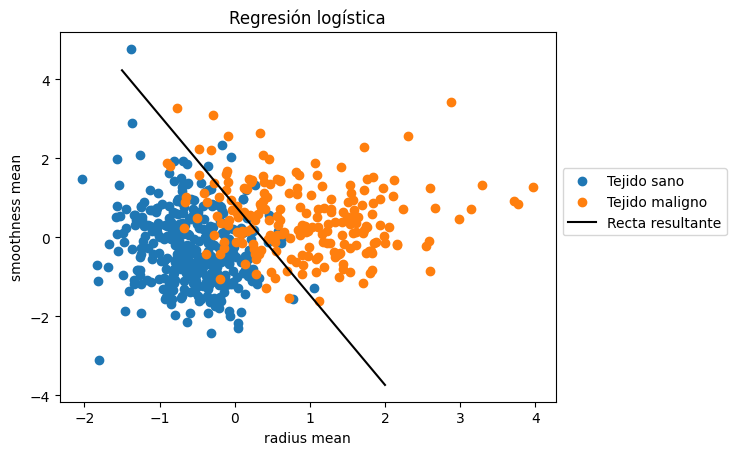

In [ ]:
# Separar por etiquetas
data_0 = []
data_1 = []

for idx in range(len(X)):
  if Y[idx] == 0:
    data_0.append(X[idx])
  else:
    data_1.append(X[idx])

x_0 = [data_0[k][0] for k in range(len(data_0))]
y_0 = [data_0[k][1] for k in range(len(data_0))]

x_1 = [data_1[k][0] for k in range(len(data_1))]
y_1 = [data_1[k][1] for k in range(len(data_1))]

# Plot regresión logística

c = -b/w[1]
m = -w[0]/w[1]
x = np.linspace(-1.5, 2, 100)
y = m*x + c

plt.scatter(x_0, y_0, label = 'Tejido sano')
plt.scatter(x_1, y_1, label = 'Tejido maligno')
plt.plot(x , y, 'k', label = 'Recta resultante')
plt.title('Regresión logística')
plt.xlabel('radius mean')
plt.ylabel('smoothness mean')
plt.legend(bbox_to_anchor = (1.0, 0.65))


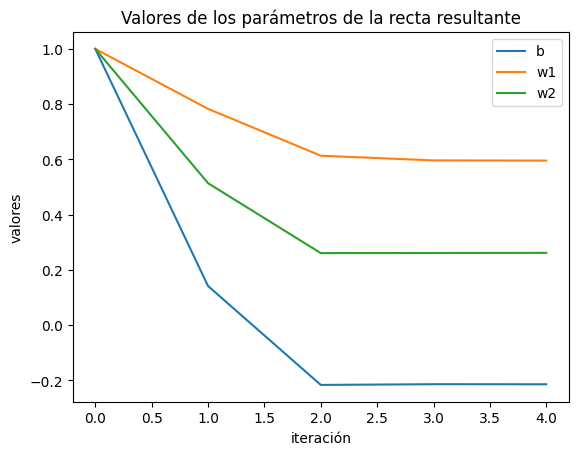

In [ ]:
# Parámetros de la recta iteración a iteración

iteraciones = [k for k in range(len(w_values))]

plt.plot(iteraciones, b_values, label = 'b')
plt.plot(iteraciones, [w_values[i][0] for i in iteraciones], label = 'w1')
plt.plot(iteraciones, [w_values[i][1] for i in iteraciones], label = 'w2')
plt.title('Valores de los parámetros de la recta resultante')
plt.xlabel('iteración')
plt.ylabel('valores')
plt.legend(loc = 'best')

Text(0, 0.5, 'valores')

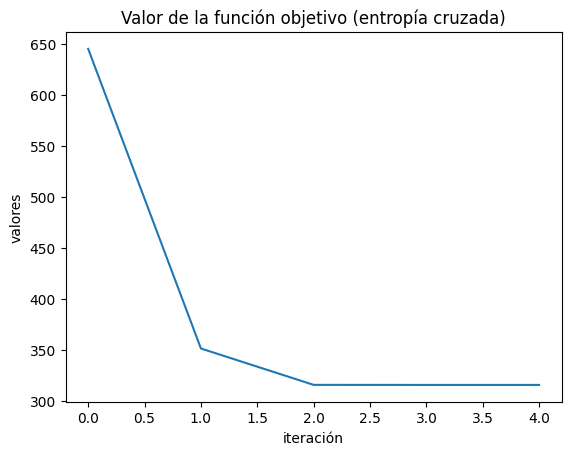

In [ ]:
# Función de entropía cruzada iteración a iteración

funcion_entropia = []

for i in iteraciones:
  theta = np.array([b_values[i], w_values[i][0],  w_values[i][1]])
  funcion_entropia.append(cost_fn(theta,H,Y.T,c=100))

plt.plot(iteraciones, funcion_entropia)
plt.title('Valor de la función objetivo (entropía cruzada)')
plt.xlabel('iteración')
plt.ylabel('valores')

# Punto 3

In [3]:
# Normalize dataframe
df_norm = normalize(df_np)

# Segment Data for cross validation: 70-15-15
train_n = int(np.ceil(np.size(df_np,0)*0.7))
test_n = int(np.floor(np.size(df_np,0)*0.15))

train_X = df_norm[0:train_n,:]                # n = 399
train_Y = df_np_labels[0:train_n]

val_X = df_norm[train_n:train_n+test_n,:]     # n = 85
val_Y = df_np_labels[train_n:train_n+test_n]

test_X = df_norm[train_n+test_n:,:]           # n = 85
test_Y = df_np_labels[train_n+test_n:]

# Regresión logística

In [4]:
# Logistic regression
def log_reg(train_X, train_Y,c = 0):
  y = train_Y.T                     # Labels
  feat = np.arange(0,30,1,dtype=int)
  H = define_H(train_X[:,feat])      # predictors/features
  theta = np.ones((np.size(H,1)))    # First guess b,w
  coef = minimize(cost_fn, x0 = theta, args=(H,y,c)) # Numeric solution
  return coef.x


In [5]:
# validation (Takes 2 min, for coffee)

c_reg = np.arange(0,100,1)
err = np.zeros_like(c_reg)
H = define_H(val_X)
for i in range(len(c_reg)):
  coeff = log_reg(train_X, train_Y,c = c_reg[i])
  z = 1 / (1 + np.exp(- (H @ coeff.T)))
  z = np.round(z)
  err[i] = class_error(val_Y,z)


<ipython-input-1-48fa852301a6>:25: RuntimeWarning: overflow encountered in exp
  z = 1 / (1 + np.exp(- (H @ theta.T)))
<ipython-input-5-44f6a0127f3f>:8: RuntimeWarning: overflow encountered in exp
  z = 1 / (1 + np.exp(- (H @ coeff.T)))


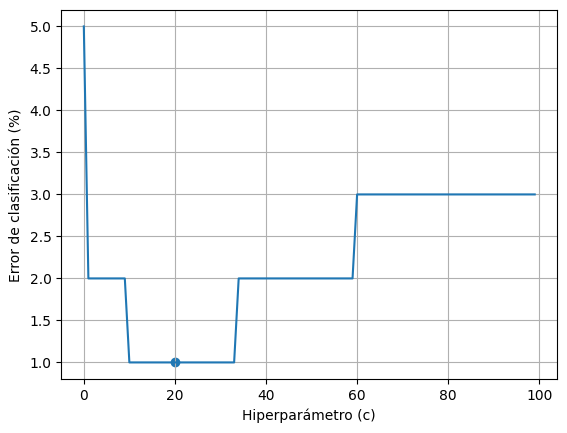

In [18]:
# Cross validation logistic regression
plt.plot(c_reg,err)
plt.grid()
plt.xlabel('Hiperparámetro (c)')
plt.ylabel('Error de clasificación (%)')
plt.scatter([20],[1])
Fig1 = "A1.png"
plt.savefig(Fig1,dpi=1000)

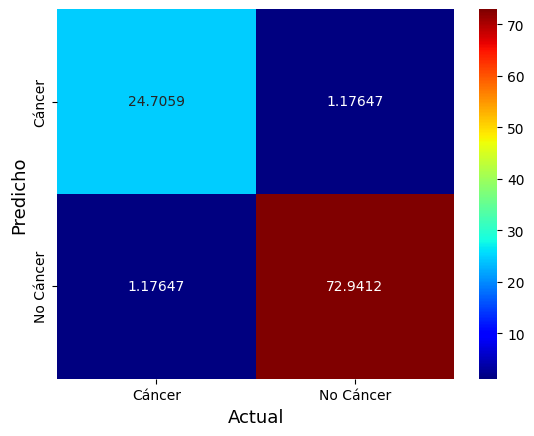

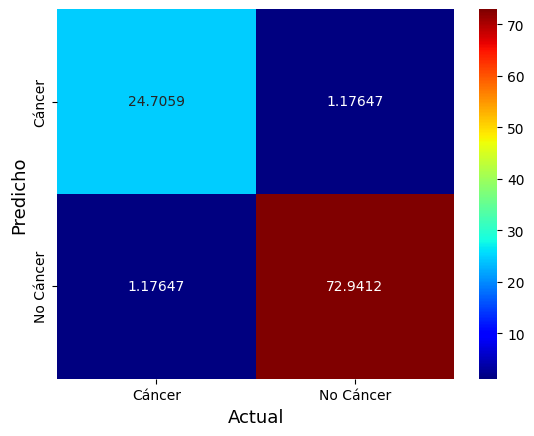

97.6470588235294

In [59]:
coeff_fin = log_reg(train_X, train_Y,c = 20) # final
H = define_H(test_X)
z = 1 / (1 + np.exp(- (H @ coeff_fin.T)))
z = np.round(z)
err_f = class_error(test_Y,z)
err_f

per_err = conf_matrix(test_Y,z)
ax = sns.heatmap(per_err,
          cmap = 'jet',
          annot=True,
          fmt='g',
          xticklabels=['Cáncer','No Cáncer'],
          yticklabels=['Cáncer','No Cáncer'])
plt.ylabel('Predicho',fontsize=13)
plt.xlabel('Actual',fontsize=13)
#plt.title('Matriz de confusión',fontsize=17)
plt.show()
Fig1 = "A2.png"
#plt.savefig(Fig1,dpi=1000)
100-err_f

# Gaussian Bayes Classifier

In [15]:
def Classificator_validation(train_X,train_Y,val_X,val_Y, prior = 0.5, lambd = 1):
  # Positive samples
  idx = train_Y[:,0]==1
  u_v, Qf = mean_cov(train_X[idx,:])
  p_x1 = mult_Gauss(val_X,u_v,Qf,lambd)

  # Negative samples
  idx = train_Y[:,0]==0
  u_v, Qf = mean_cov(train_X[idx,:])
  p_x0 = mult_Gauss(val_X,u_v,Qf,lambd)

  # Classification
  prior_c0 = prior  #
  prior_c1 = 1 - prior_c0

  c0 = p_x0 * prior_c0
  c1 = p_x1 * prior_c1
  C = np.vstack([c0,c1])
  Cf = np.argmax(C,0)

  err = class_error(val_Y,Cf)
  return [err,Cf]

In [16]:
lam = np.arange(0,1,0.01)
error_vec = np.zeros_like(lam)
for i in range(len(lam)):
  error_vec[i], Cf = Classificator_validation(train_X,train_Y,val_X,val_Y, prior = 0.5, lambd = lam[i])

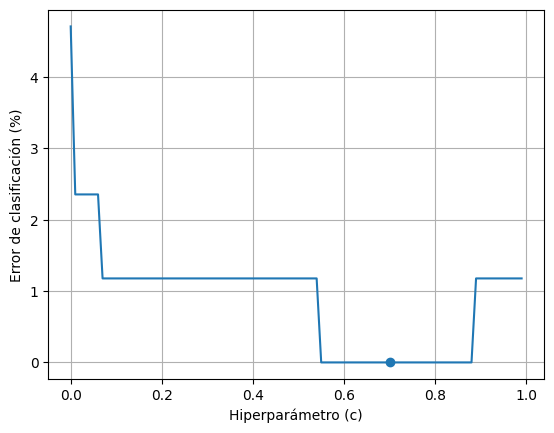

In [22]:
plt.plot(lam,error_vec)
plt.grid()
plt.xlabel('Hiperparámetro (c)')
plt.ylabel('Error de clasificación (%)')
plt.scatter([0.7],[0])
Fig1 = "A3.png"
plt.savefig(Fig1,dpi=1000)

In [28]:
error_fin, Cf_fin = Classificator_validation(train_X,train_Y,test_X,test_Y, prior = 0.5, lambd = 0.7)
print(100-error_fin)

97.6470588235294


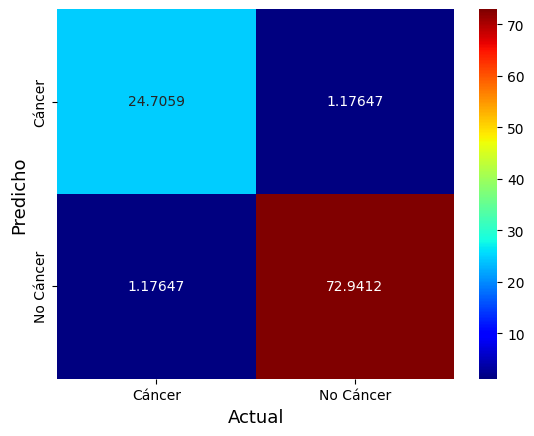

array([[24.70588235,  1.17647059],
       [ 1.17647059, 72.94117647]])

In [29]:
conf_matrix(test_Y,Cf_fin)

(array([44.,  7.,  6.,  3.,  2.,  0.,  0.,  0.,  0.,  1.]),
 array([7.13078226e-05, 5.83192194e-02, 1.16567131e-01, 1.74815043e-01,
        2.33062954e-01, 2.91310866e-01, 3.49558777e-01, 4.07806689e-01,
        4.66054600e-01, 5.24302512e-01, 5.82550424e-01]),
 <BarContainer object of 10 artists>)

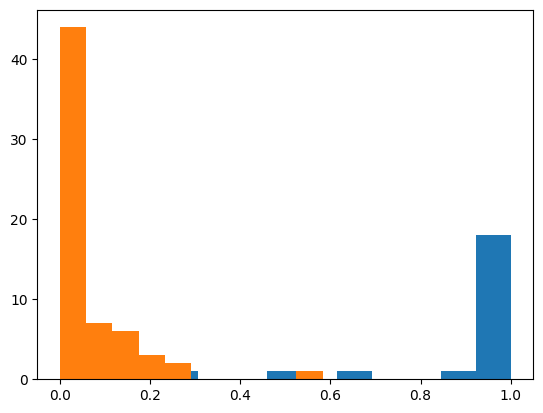

In [53]:
# Positive samples - Gaussian Bayes Classifier
prior_c0 = 0.5 #
prior_c1 = 1 - prior_c0
lambd = 0.7

### FOR CLASS 1

idx = train_Y[:,0]==1
u_v, Qf = mean_cov(train_X[idx,:])
idx1 = test_Y[:,0]==1
p_x1 = mult_Gauss(test_X[idx1,:],u_v,Qf,lambd) # p(x|C = 1) - Class likelihood
idx = train_Y[:,0]==0
u_v1, Qf1 = mean_cov(train_X[idx,:])
p_x2 = mult_Gauss(test_X[idx1,:],u_v1,Qf1,lambd) # p(x|C = 0)

evidence = (p_x1 * prior_c1) + (p_x2 * prior_c0)
c1 = (p_x1 * prior_c1) / evidence
plt.hist(c1)

### FOR CLASS 0
idx = train_Y[:,0]==1
u_v, Qf = mean_cov(train_X[idx,:])
idx1 = test_Y[:,0]==0
p_x1 = mult_Gauss(test_X[idx1,:],u_v,Qf,lambd) # p(x|C = 0) - Class likelihood
idx = train_Y[:,0]==0
u_v1, Qf1 = mean_cov(train_X[idx,:])
p_x2 = mult_Gauss(test_X[idx1,:],u_v1,Qf1,lambd) # p(x|C = 1)

evidence = (p_x1 * prior_c1) + (p_x2 * prior_c0)
c0 = (p_x1 * prior_c1) / evidence
plt.hist(c0)


(array([ 1.,  1.,  0.,  1.,  0.,  0.,  0.,  3.,  0., 16.]),
 array([0.49636299, 0.54672114, 0.59707929, 0.64743743, 0.69779558,
        0.74815373, 0.79851188, 0.84887003, 0.89922818, 0.94958632,
        0.99994447]),
 <BarContainer object of 10 artists>)

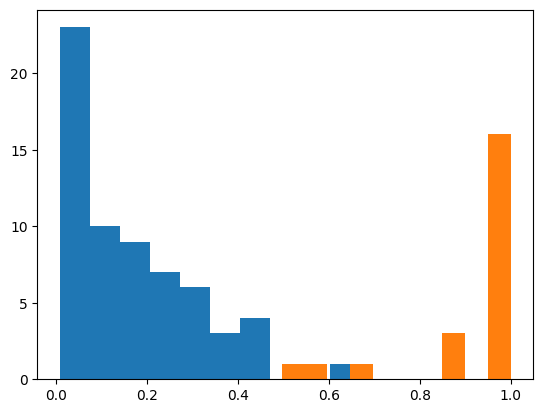

In [55]:
# Positive samples - Logistic regression
coeff_fin = log_reg(train_X, train_Y,c = 20) # final
H = define_H(test_X)
z = 1 / (1 + np.exp(- (H @ coeff_fin.T)))


idx2 = test_Y[:,0]==0
plt.hist(z[idx2])

idx1 = test_Y[:,0]==1
plt.hist(z[idx1])


In [56]:
df1 = pd.DataFrame(z[idx1])
df1.to_excel("output1.xlsx")
df1 = pd.DataFrame(z[idx2])
df1.to_excel("output2.xlsx")
##
df1 = pd.DataFrame(c1)
df1.to_excel("output3.xlsx")
df1 = pd.DataFrame(c0)
df1.to_excel("output4.xlsx")